<a href="https://www.kaggle.com/code/hajaribrahiem/cv-binary-classification-eyes-inceptionv3?scriptVersionId=129616652" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# About Data
Kaggle `Eyes dataset` contains images of eyes which is closed and open which helps to know whether the person blinks or not. It is a binary classification. 
Data size around `4850` files.

# Import Libs ⚙️

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import warnings
warnings.filterwarnings('ignore')

import urllib.request
import os
import zipfile
import random
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile


# Data Visualization
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls
import PIL

In [3]:
# Constants 
SPLIT_SIZE = .9
BATCH_SIZE = 50
IMG_SIZE = 150
EPOCHS=20

In [4]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Load Data

In [5]:
# Create some folders that will store the training and test data.


TRAINING_DIR ="/kaggle/input/eyes-dataset/dataset/train/"
TESTING_DIR ="/kaggle/input/eyes-dataset/dataset/val"

TRAINING_OPEN_DIR = "/kaggle/input/eyes-dataset/dataset/train/open/"
TRAINING_CLOSED_DIR = "/kaggle/input/eyes-dataset/dataset/train/closed"

TESTING_OPEN_DIR = "/kaggle/input/eyes-dataset/dataset/val/open/"
TESTING_CLOSED_DIR = "/kaggle/input/eyes-dataset/dataset/val/closed/"

try:
    os.mkdir('/open-v-closed')
    os.mkdir(TRAINING_DIR)
    os.mkdir(TESTING_DIR)
    os.mkdir(TRAINING_OPEN_DIR)
    os.mkdir(TRAINING_CLOSED_DIR)
    os.mkdir(TESTING_OPEN_DIR)
    os.mkdir(TESTING_CLOSED_DIR)
except OSError:
  pass


# Explore & Visualize Data  📊

In [6]:
# Check Splitting.
print("Number of Open-Eye images - Train:",len(os.listdir(TRAINING_OPEN_DIR)))
print("Number of Closed-Eye images - Train:", len(os.listdir(TRAINING_CLOSED_DIR)))

print("Number of Open-Eye images - Val:",len(os.listdir(TESTING_OPEN_DIR)))
print("Number of Closed-Eye images - Val:", len(os.listdir(TESTING_CLOSED_DIR)))



Number of Open-Eye images - Train: 1922
Number of Closed-Eye images - Train: 1860
Number of Open-Eye images - Val: 543
Number of Closed-Eye images - Val: 525


In [7]:
# visualize the number of images in each class in the training dataset
def CheckDataInfo(TRAIN_DIR, TEST_DIR):
  # Check the class names
  class_names = sorted(os.listdir(TRAIN_DIR))
  n_classes = len(class_names)
  global NUM_CLASSES
  NUM_CLASSES = n_classes

  # Show
  print(f"Total number of classes: {n_classes}")
  print(f"Classes: {class_names}")
  print('\n')

  # Check the number of images in each class in the test dataset
  print("Total number of TRAIN imgs :", len ( glob(f"{TRAIN_DIR}/*/*")))
  No_images_per_class = []
  Class_name = []
  for i in os.listdir(TRAIN_DIR):
    Class_name.append(i)
    train_class = os.listdir(os.path.join(TRAIN_DIR,i))
    print('Number of images in {}={}'.format(i,len(train_class)))
    No_images_per_class.append(len(train_class))
  print('\n')


  # visualize the number of images in each class in the training dataset
  VisualizeClassesDistribution (TRAIN_DIR,Class_name ,No_images_per_class )


def VisualizeClassesDistribution (Original_Train_DIR ,Class_name ,No_images_per_class ):

  # Calculate class distribution
  class_dis = [len(os.listdir(Original_Train_DIR + name)) for name in Class_name]

  # Visualize using interactive pie chart
  pie_chart = px.pie(values=class_dis, names=Class_name, color=Class_name)
#   pie_chart.update_layout({'title':{'text':"Class Distribution"}})
  pie_chart.update_layout(
        title={'text': "Class Distribution"},
        width=400,  # Set the width of the chart to 800 pixels
        height=400  # Set the height of the chart to 600 pixels
    )
  pie_chart.show()

#   # Visualize using interactive bar chart
#   bar_chart = px.bar(y=class_dis, x=Class_name, color=Class_name)
#   bar_chart.show()


In [8]:
CheckDataInfo(TRAINING_DIR , TESTING_DIR )

Total number of classes: 2
Classes: ['closed', 'open']


Total number of TRAIN imgs : 3782
Number of images in closed=1860
Number of images in open=1922




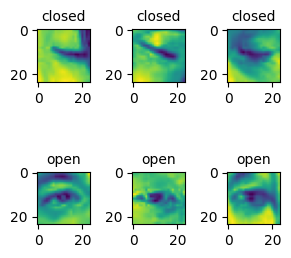

In [9]:
def ImgVisulalization (TRAIN_DIR , NUM_CLASSES):
  # Visualize the images in the dataset
  fig, axs = plt.subplots(NUM_CLASSES, 3, figsize = (3,3))
  count = 0
  # for every class in the dataset
  for i in os.listdir(TRAIN_DIR):
    # get the list of all images that belong to a particular class
    train_class = os.listdir(os.path.join(TRAIN_DIR, i))
    
    # plot 3 images per class
    for j in range(3):
      img = os.path.join(TRAIN_DIR, i, train_class[j])
      axs[count][j].set_title (i , fontsize=10)
      axs[count][j].imshow(PIL.Image.open(img))  
    count += 1

  fig.tight_layout()
  plt.show()

ImgVisulalization (TRAINING_DIR , NUM_CLASSES)

# Data augmentation

Using the `ImageDataGenerator` to perform data augmentation like:
- Rotating 
- Flipping 

allows to generate training data that is more varied, and can help the model generalize better during training.

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory (TRAINING_DIR, 
                                                     batch_size = BATCH_SIZE,
                                                     class_mode='binary',
                                                     target_size=(IMG_SIZE, IMG_SIZE))

val_datagen = ImageDataGenerator(rescale=1./255,)
val_generator = val_datagen.flow_from_directory(TESTING_DIR, 
                                                  batch_size = BATCH_SIZE,
                                                  class_mode='binary',
                                                  target_size=(IMG_SIZE, IMG_SIZE))

Found 3780 images belonging to 2 classes.
Found 1068 images belonging to 2 classes.


# Bulid Model - Transfer Learning ⚒️ ⚙️

In [11]:
# InceptionV3 model
# First : load the pre-trained weights of the model.
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                include_top=False,  #disable final layers of InceptionV3 
                                weights=None) # dont Instantiate weights with randome numbers , as we use pre-trained weights

# load pre-trained weights
pre_trained_model.load_weights(weights_file)

# freeze the existing layers so that they aren't trained on your downstream task 
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

In [12]:
#  get a reference to the last layer, 'mixed7' to add some layers after this last layer
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


### Add Our Own TOP Layers
Add some layers to train on our data.
- `Flatten`: Take the output of the `last_layer` and flatten it to a vector.
- `Dense`: Add a dense layer with a relu activation.
- `Dense`: Add a dense layer with a sigmoid activation.  The sigmoid will scale the output to range from 0 to 1, and allow you to interpret the output as a prediction between two categories.


In [13]:
# Add our own TOP layers
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x= layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# create the model object
model = Model(pre_trained_model.input, x)


In [14]:
#Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

# Train Model 🔥 🌡️

In [15]:
#Train Model
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=EPOCHS,
                    verbose=2)

Epoch 1/20
76/76 - 44s - loss: 0.4521 - acc: 0.8077 - val_loss: 0.1590 - val_acc: 0.9373 - 44s/epoch - 575ms/step
Epoch 2/20
76/76 - 26s - loss: 0.2739 - acc: 0.8862 - val_loss: 0.1249 - val_acc: 0.9504 - 26s/epoch - 347ms/step
Epoch 3/20
76/76 - 26s - loss: 0.2455 - acc: 0.8995 - val_loss: 0.1430 - val_acc: 0.9410 - 26s/epoch - 343ms/step
Epoch 4/20
76/76 - 26s - loss: 0.2244 - acc: 0.9093 - val_loss: 0.2530 - val_acc: 0.8989 - 26s/epoch - 342ms/step
Epoch 5/20
76/76 - 27s - loss: 0.2023 - acc: 0.9159 - val_loss: 0.1279 - val_acc: 0.9476 - 27s/epoch - 351ms/step
Epoch 6/20
76/76 - 26s - loss: 0.1973 - acc: 0.9188 - val_loss: 0.1105 - val_acc: 0.9541 - 26s/epoch - 338ms/step
Epoch 7/20
76/76 - 27s - loss: 0.1806 - acc: 0.9270 - val_loss: 0.1267 - val_acc: 0.9504 - 27s/epoch - 351ms/step
Epoch 8/20
76/76 - 27s - loss: 0.1848 - acc: 0.9275 - val_loss: 0.1039 - val_acc: 0.9560 - 27s/epoch - 350ms/step
Epoch 9/20
76/76 - 27s - loss: 0.1666 - acc: 0.9325 - val_loss: 0.1151 - val_acc: 0.9494

# Plot Accuracy Curve  📈 

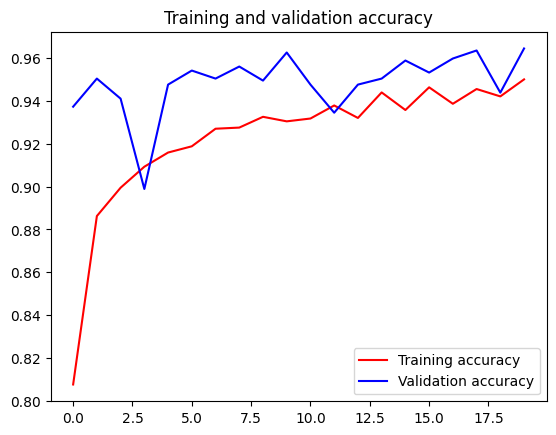

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()
